<a href="https://colab.research.google.com/github/tyoc213/fastai_xla_extensions/blob/explorations1/explore_nbs/Exploration_MNIST_TINY_Lenet_Adam_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup XLA first (so that there are no conflicts with torch)

Some times whem importing xm you get a `import _XLAC error`  because it problably exist a version mismatch somewhere.

In [1]:
VERSION = "nightly"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4994  100  4994    0     0  43426      0 --:--:-- --:--:-- --:--:-- 43426


In [2]:
#!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!python pytorch-xla-env-setup.py

Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Uninstalling torch-1.6.0a0+bf2bbd9:
  Successfully uninstalled torch-1.6.0a0+bf2bbd9
Uninstalling torchvision-0.7.0a0+a6073f0:
  Successfully uninstalled torchvision-0.7.0a0+a6073f0
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
| [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.        

# Install fastai2 if needed

In [3]:
!pip uninstall fastai
!pip install torchvision
!pip install git+https://github.com/fastai/fastcore
!pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-ije10mx_
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-ije10mx_
  Created wheel for fastcore: filename=fastcore-0.1.18-cp36-none-any.whl size=28891 sha256=eb1aee28b42c5df372d48c361e81857982e124c0f0993fcae902d6eb9f67c474
  Stored in directory: /tmp/pip-ephem-wheel-cache-jbs6l2f_/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-5ptqd9i2
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-5ptqd9i2
  Created wheel for fastai2: filename=fastai2-0.0.18-cp36-none-any.whl size=193924 sha256=f5b1e1030648c6d159d32fa3f2c53d036f92e61837057064ef7134ef20e69b8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-chqaha9b/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [4]:
from fastai2.vision.all import *

[('__call__', <function LevelMapper.__call__ at 0x7f4e5cadaae8>), ('__init__', <function LevelMapper.__init__ at 0x7f4e5cadaa60>)]
[('__call__', <function BalancedPositiveNegativeSampler.__call__ at 0x7f4e5ca156a8>), ('__init__', <function BalancedPositiveNegativeSampler.__init__ at 0x7f4e5ca15620>)]
[('__init__', <function BoxCoder.__init__ at 0x7f4e5c9a9ae8>), ('decode', <function BoxCoder.decode at 0x7f4e5c9a9c80>), ('decode_single', <function BoxCoder.decode_single at 0x7f4e5c9a9d08>), ('encode', <function BoxCoder.encode at 0x7f4e5c9a9b70>), ('encode_single', <function BoxCoder.encode_single at 0x7f4e5c9a9bf8>)]
[('__call__', <function Matcher.__call__ at 0x7f4e5c9a99d8>), ('__init__', <function Matcher.__init__ at 0x7f4e5c9a9e18>), ('set_low_quality_matches_', <function Matcher.set_low_quality_matches_ at 0x7f4e5c9a9a60>)]
[('__init__', <function ImageList.__init__ at 0x7f4e5c9a9ea0>), ('to', <function ImageList.to at 0x7f4e5c9a2048>)]
[('__init__', <function Timebase.__init__ at

In [5]:
path = untar_data(URLs.MNIST_TINY)
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7331.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7331.png
    applying parent_label gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(1))
    applying Resize gives
      (PILImageBW mode=L size=28x28, TensorCa

## Lenet implementations

In [6]:
class MyLenet(nn.Module):
    """Lenet with convs and F.max_pool2d"""
    def __init__(self):
        super(MyLenet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6,16,3)
        self.hiden4 = nn.Linear(400, 2) # 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.hiden4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class Lenet2(nn.Module):
    """Lenet with layers"""
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # set 3 for first item if RGB
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # Only 2 outputs (3 and 7) instead of 10
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Train with TPU

In [12]:
!pip install git+https://github.com/butchland/fastai_xla_extensions

  Cloning https://github.com/butchland/fastai_xla_extensions to /tmp/pip-req-build-4p5i30si
  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-4p5i30si
  Created wheel for fastai-xla-extensions: filename=fastai_xla_extensions-0.0.1-cp36-none-any.whl size=10843 sha256=ebb9e905dc89331fed20ef4a073b0b832a74b891dd582e6be605c66a96ac2e91
  Stored in directory: /tmp/pip-ephem-wheel-cache-v3h4fqc3/wheels/3c/d5/c1/7a96c15b4e74b5d1ec0bc6c29fcaf36501791ce2d9a88a8cea
Successfully built fastai-xla-extensions


In [17]:
## Load via TPU

(device(type='xla', index=1), (#2) ['3','7'], None)

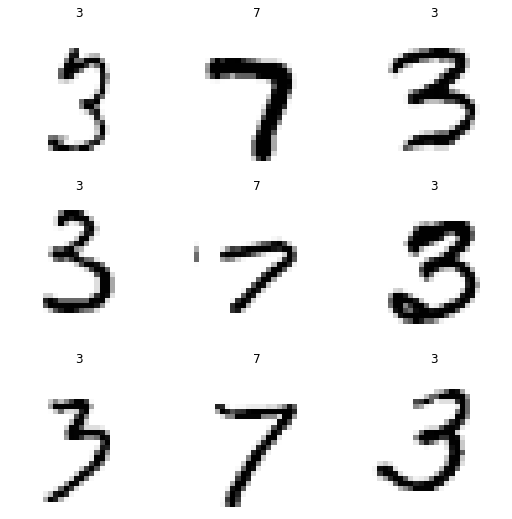

In [19]:
tpu_device = xm.xla_device()
# Use same datablock, but load with TPU
dls_tpu = datablock.dataloaders(path, device=tpu_device)
dls_tpu.device, dls_tpu.vocab, dls_tpu.show_batch()

## Setup Learner on TPU

In [20]:
import torch_xla.core.xla_model as xm
from fastai_xla_extensions.core import XLAOptFuncWrapper

wrapped_adam = XLAOptFuncWrapper(Adam)
learner = Learner(dls_tpu, Lenet2(), metrics=accuracy, opt_func=wrapped_adam)
learner.summary()

Lenet2 (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 6 x 26 x 26     60         True      
________________________________________________________________
Conv2d               64 x 16 x 11 x 11    880        True      
________________________________________________________________
Linear               64 x 120             48,120     True      
________________________________________________________________
Linear               64 x 84              10,164     True      
________________________________________________________________
Linear               64 x 2               170        True      
________________________________________________________________

Total params: 59,394
Total trainable params: 59,394
Total non-trainable params: 0

Optimizer used: <fastai_xla_extensions.core.XLAOptFuncWrapper object at 0x7f4e4e49b908>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEval

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.0010000000474974513)

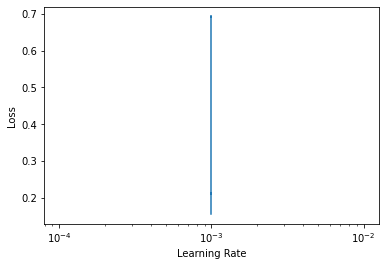

In [21]:
%time
learner.lr_find()

In [22]:
learner.fit(10, lr=0.05) # 0.5 comes from GPU lr_find

epoch,train_loss,valid_loss,accuracy,time
0,0.673648,0.630973,0.968526,00:03
1,0.607995,0.401922,0.972818,00:02
2,0.469843,0.104262,0.979971,00:01
3,0.351770,0.063194,0.978541,00:01
4,0.279521,0.046550,0.981402,00:02
5,0.231051,0.039896,0.984263,00:01
6,0.193287,0.036071,0.987124,00:02
7,0.165132,0.037223,0.987124,00:01
8,0.143310,0.032102,0.989986,00:01
9,0.126264,0.047134,0.984263,00:01
